# Персонализация предложений для удержания клиентов интернет-магазина «В один клик»
_____
**Описание исследования:**
Интернет-магазин «В один клик» заметил снижение покупательской активности среди постоянных клиентов. Привлечение новой аудитории перестало быть эффективным, поэтому компания решила сфокусироваться на удержании текущих клиентов с помощью персонализированных предложений. Для этого необходимо разработать модель машинного обучения, которая будет предсказывать интересы и предпочтения клиентов, чтобы предлагать наиболее релевантные товары и повысить активность.    
_____
**Цель исследования.**
Разработать и внедрить модель машинного обучения для персонализации предложений постоянным клиентам интернет-магазина с целью повышения их покупательской активности и удержания.
_____
**Задачи исследования.**
1. Промаркеровать уровень финансовой активности постоянных покупателей.
2. Собрать данные по группам клиентов.
3. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
4. Определить прибыльность клиента за последние 3 месяца.
5. Выделить сегменты покупателей и разработать для них персонализированные предложения.
_____
**Задачи исследования.**
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

#  Загрузка данных

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.prefix)

!pip install phik -q
!pip install shap -q
!pip install --upgrade scikit-learn -q
# !pip install --upgrade pandas==1.5.0 -q

/opt/conda


In [2]:
# основные библиотеки
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# Phik корреляция
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# модели машинного обучения
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# предобработка данных
from sklearn.preprocessing import (StandardScaler, 
                                   OrdinalEncoder, 
                                   OneHotEncoder,
                                   LabelEncoder,
                                   MinMaxScaler,
                                   RobustScaler)

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# метрики качества моделей
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             precision_score, 
                             recall_score, 
                             r2_score, 
                             roc_auc_score, 
                             roc_curve,
                             f1_score,
                             auc)

# разбивка данных и поиск гиперпараметров
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     StratifiedKFold,
                                     RandomizedSearchCV, 
                                     cross_val_score)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# загрузка данных
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
try:
    market_money = pd.read_csv('/datasets/market_money.csv')
except:
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
try:
    market_time = pd.read_csv('/datasets/market_time.csv')
except:
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
try:
    money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')
except:
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal = ',')
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


 ## Информация о таблице data_market_file

In [8]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [9]:
market_file.shape

(1300, 13)

In [10]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [11]:
market_file.duplicated().sum()

0

 ## Информация о таблице data_market_money

In [12]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [13]:
market_money.shape

(3900, 3)

In [14]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [15]:
market_money.duplicated().sum()

0

 ## Информация о таблице data_market_time

In [16]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [17]:
market_time.shape

(2600, 3)

In [18]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [19]:
market_time.duplicated().sum()

0

 ## Информация о таблице data_money

In [20]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [21]:
money.shape

(1300, 2)

In [22]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [23]:
money.duplicated().sum()

0

 ### Выводы:
1. Данные соответствуют описанию.
2. Тип данных соответствует.
3. Пропусков данных нет.
4. Явных дубликатов нет.

# Предобработка данных

In [24]:
# переименование столбцов
import re

for df in [market_file, market_money, market_time, money]:
    df.columns = [
        re.sub(r'(?<!^)(?=[A-Z])', '_', col)
        .replace(' ', '_')
        .lower()
        for col in df.columns
    ]

In [25]:
market_file.head(1)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5


In [26]:
market_money.head(1)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0


In [27]:
market_time.head(1)

,id,период,минут
0,215348,текущий_месяц,14


In [28]:
money.head(1)

,id,прибыль
0,215348,0.98


In [29]:
# поиск неявных дублей и замена значений
market_file['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [30]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [31]:
market_file['тип_сервиса'].replace({'стандартт': 'стандарт'}, inplace=True)

In [32]:
market_file['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [37]:
market_file['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [42]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [44]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [45]:
market_time['период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'}, inplace=True)

 ### Выводы:
1. Переименованы столбцы.
2. Исправлены опечатки в данных.
3. Тип данных соответствует.

# Исследовательский анализ данных

In [48]:
# статистический анализ данных таблиц
market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


In [49]:
market_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [50]:
# удаление выбросов
market_money['выручка'].sort_values(ascending=False).head()
market_money = market_money.query('выручка != 106862.2 and выручка != 0')

# или меняем "ошибки ввода" на медианное значение

# median_value = market_money.loc[(market_money['выручка'] > 0) & (market_money['выручка'] < 8000), 'выручка'].median()
# market_money.loc[(market_money['выручка'] == 0) | (market_money['выручка'] > 8000), 'выручка'] = median_value

In [51]:
market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [52]:
money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


In [53]:
# создаём функции для графиков
def gistabox (data, column, bins, xlim=None, xticks=None, hist_title=None, hist_xlabel=None, box_xlabel=None):
    plt.figure(figsize=(12, 6))
    plt.hist(data[column], bins=bins)
    if xlim:
        plt.xlim(xlim)
    if xticks is not None:
        plt.xticks(xticks)
    if hist_title:
        plt.title(hist_title)
    if hist_xlabel:
        plt.xlabel(hist_xlabel)
    plt.ylabel('Частота')
    plt.show()
    plt.figure(figsize=(12, 2))
    sns.boxplot(x=data[column], color='skyblue')
    if box_xlabel:
        plt.xlabel(box_xlabel)
    plt.show()
    
def gistakat (data, column, plot_type='both', labels=None, colors=None, title=None):
    values = data[column].value_counts()
    if plot_type in ['pie', 'both']:
        plt.figure(figsize=(7, 5))
        plt.pie(
            values,
            labels=labels if labels else values.index.tolist(),
            autopct='%1.1f%%',
            colors=colors
        )
        plt.title(title if title else f'Распределение {column}')
        plt.show()
        
    if plot_type in ['bar', 'both']:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=column, data=data, palette=colors)
        plt.title(title if title else f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.xticks(rotation=45)
        plt.show()

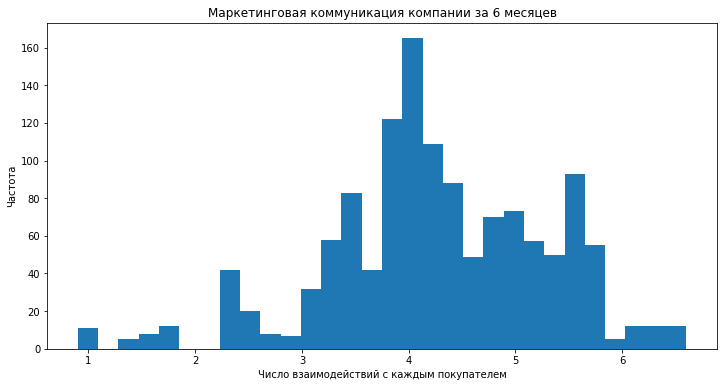

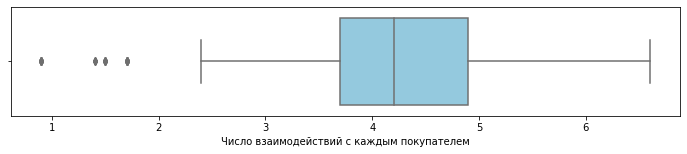

In [54]:
gistabox(
    data = market_file, 
    column = 'маркет_актив_6_мес', 
    bins = 30, 
    hist_title = 'Маркетинговая коммуникация компании за 6 месяцев',
    hist_xlabel = 'Число взаимодействий с каждым покупателем', 
    box_xlabel = 'Число взаимодействий с каждым покупателем',
)

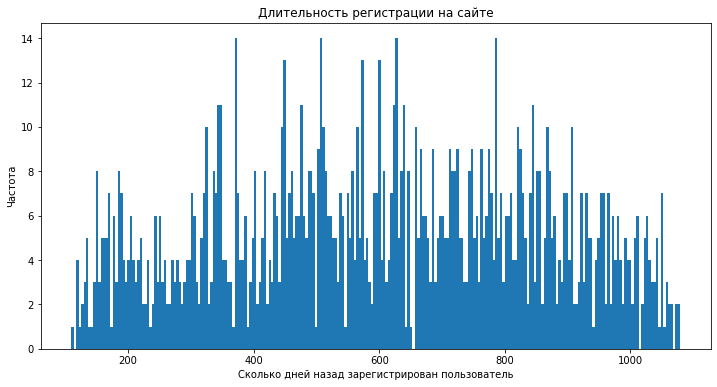

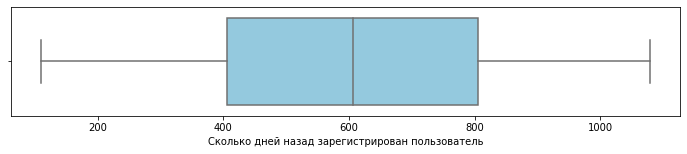

In [55]:
gistabox(
    data = market_file, 
    column = 'длительность', 
    bins = 250, 
    hist_title = 'Длительность регистрации на сайте',
    hist_xlabel = 'Сколько дней назад зарегистрирован пользователь', 
    box_xlabel = 'Сколько дней назад зарегистрирован пользователь',
)

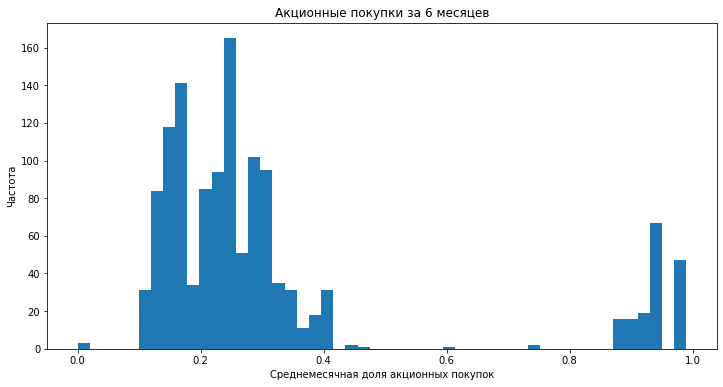

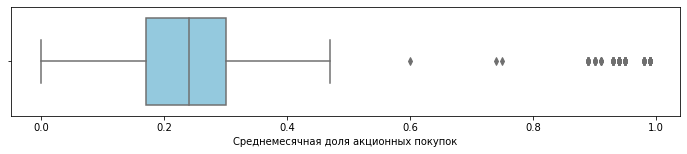

In [56]:
gistabox(
    data = market_file, 
    column = 'акционные_покупки', 
    bins = 50, 
    hist_title = 'Акционные покупки за 6 месяцев',
    hist_xlabel = 'Среднемесячная доля акционных покупок', 
    box_xlabel = 'Среднемесячная доля акционных покупок',
)

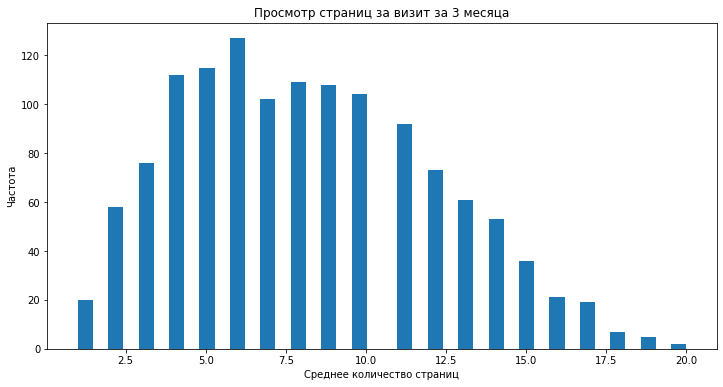

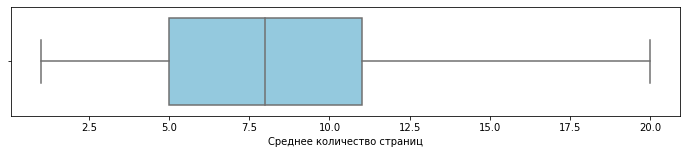

In [57]:
gistabox(
    data = market_file, 
    column = 'страниц_за_визит', 
    bins = 40, 
    hist_title = 'Просмотр страниц за визит за 3 месяца',
    hist_xlabel = 'Среднее количество страниц', 
    box_xlabel = 'Среднее количество страниц',
)

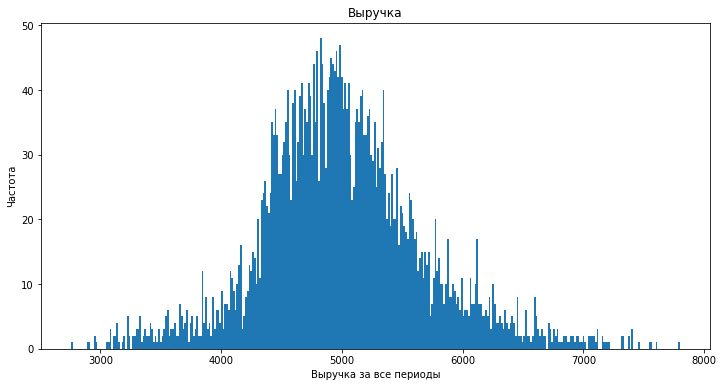

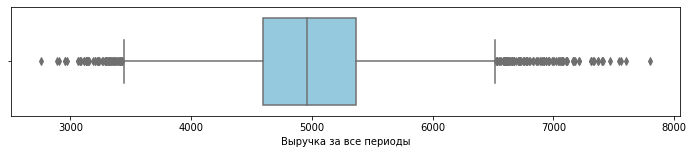

In [58]:
gistabox(
    data = market_money, 
    column = 'выручка', 
    bins = 350, 
    hist_title = 'Выручка',
    hist_xlabel = 'Выручка за все периоды', 
    box_xlabel = 'Выручка за все периоды',
)

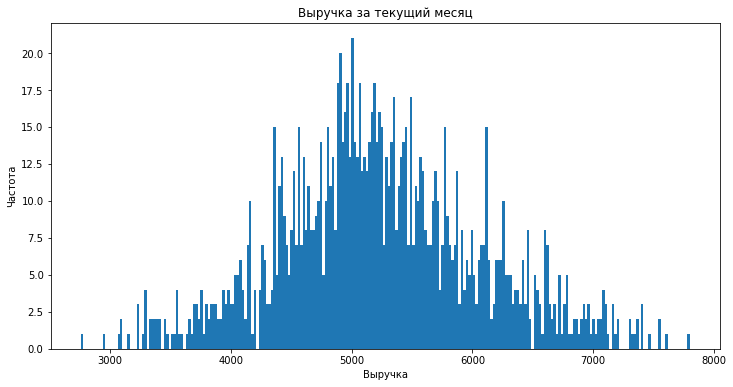

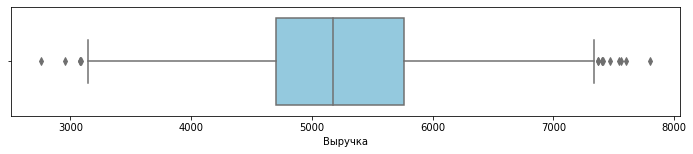

In [59]:
market_money_current_month = market_money.query("период == 'текущий_месяц'")
gistabox(
    data = market_money_current_month, 
    column = 'выручка', 
    bins = 250, 
    hist_title = 'Выручка за текущий месяц',
    hist_xlabel = 'Выручка', 
    box_xlabel = 'Выручка',
)

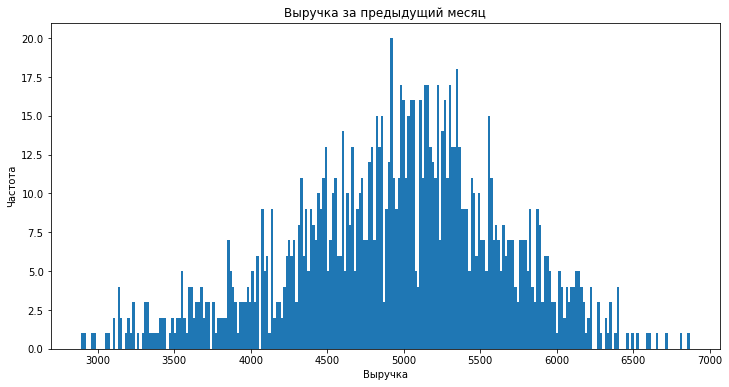

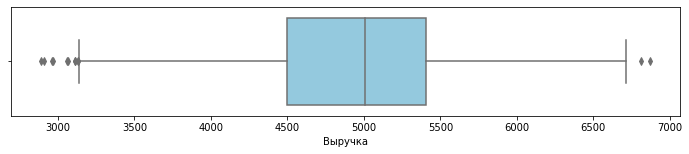

In [60]:
market_money_previous_month = market_money.query("период == 'предыдущий_месяц'")
gistabox(
    data = market_money_previous_month, 
    column = 'выручка', 
    bins = 250, 
    hist_title = 'Выручка за предыдущий месяц',
    hist_xlabel = 'Выручка', 
    box_xlabel = 'Выручка',
)

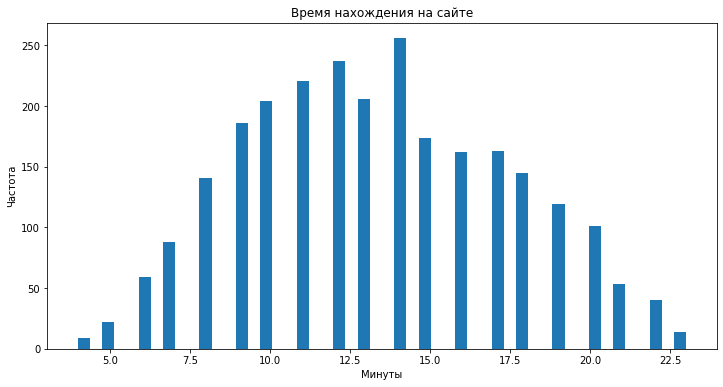

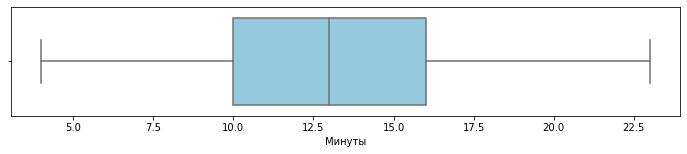

In [61]:
gistabox(
    data = market_time, 
    column = 'минут', 
    bins = 50, 
    hist_title = 'Время нахождения на сайте',
    hist_xlabel = 'Минуты', 
    box_xlabel = 'Минуты'
)

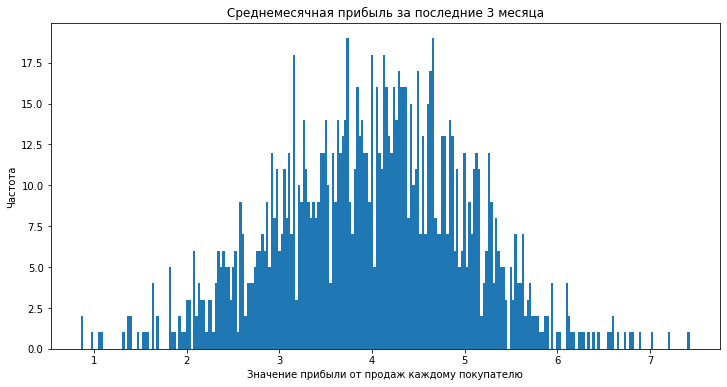

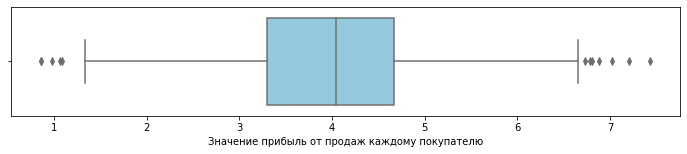

In [62]:
gistabox(
    data = money, 
    column = 'прибыль', 
    bins = 250, 
    hist_title = 'Среднемесячная прибыль за последние 3 месяца',
    hist_xlabel = 'Значение прибыли от продаж каждому покупателю', 
    box_xlabel = 'Значение прибыль от продаж каждому покупателю'
)

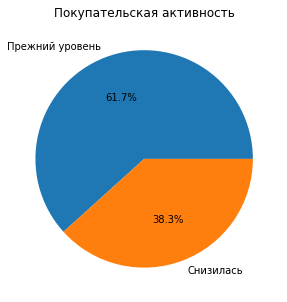

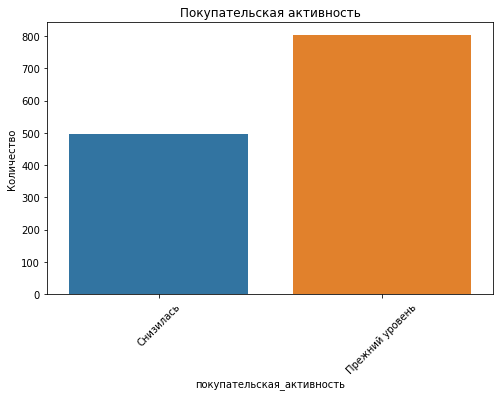

In [63]:
gistakat(
    data = market_file,
    column = 'покупательская_активность',
    title = 'Покупательская активность'
)

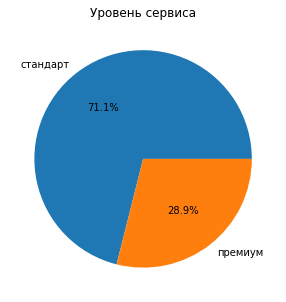

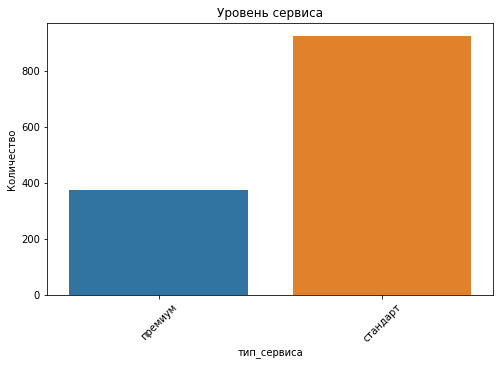

In [64]:
gistakat(
    data = market_file,
    column = 'тип_сервиса',
    title = 'Уровень сервиса'
)

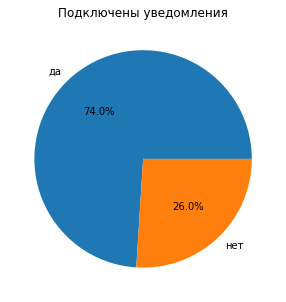

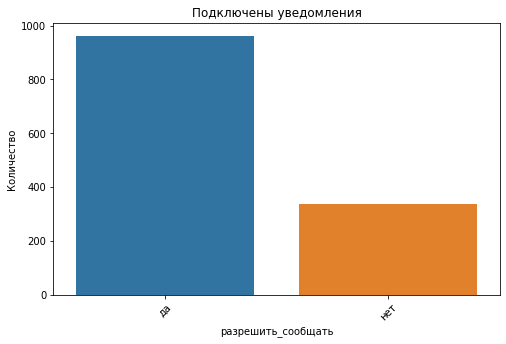

In [65]:
gistakat(
    data = market_file,
    column = 'разрешить_сообщать',
    title = 'Подключены уведомления'
)

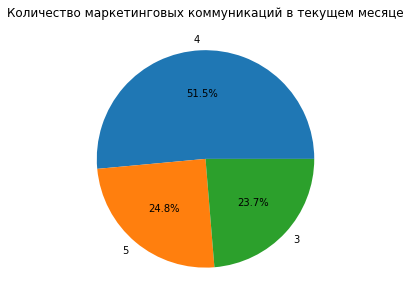

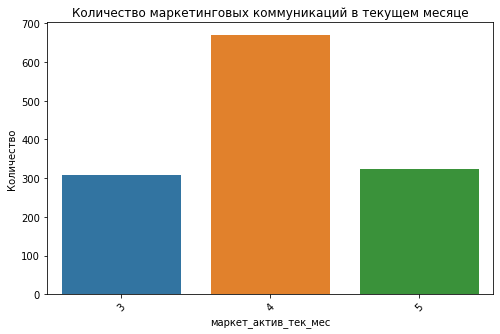

In [66]:
gistakat(
    data = market_file,
    column = 'маркет_актив_тек_мес',
    title = 'Количество маркетинговых коммуникаций в текущем месяце'
)

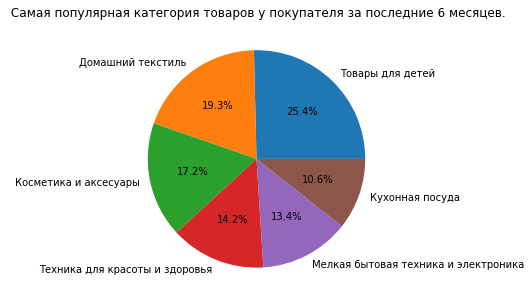

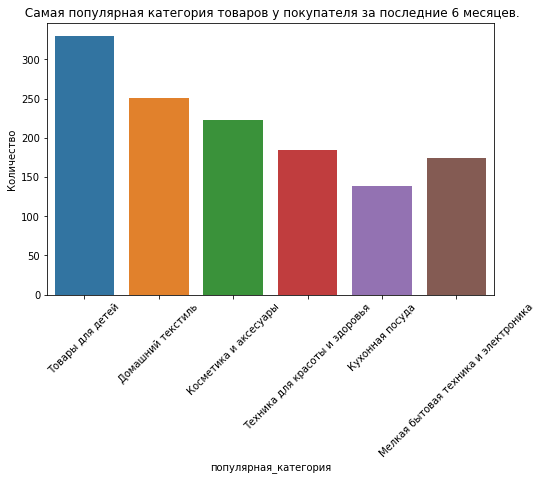

In [67]:
gistakat(
    data = market_file,
    column = 'популярная_категория',
    title = ' Самая популярная категория товаров у покупателя за последние 6 месяцев.'
)

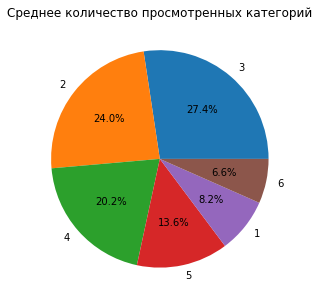

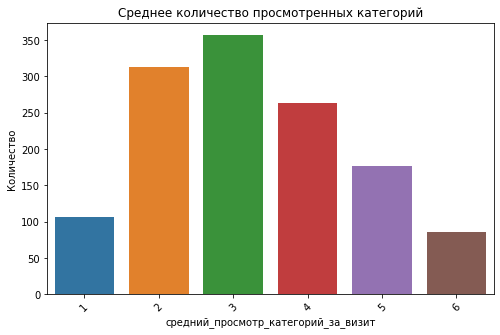

In [68]:
gistakat(
    data = market_file,
    column = 'средний_просмотр_категорий_за_визит',
    title = 'Среднее количество просмотренных категорий'
)

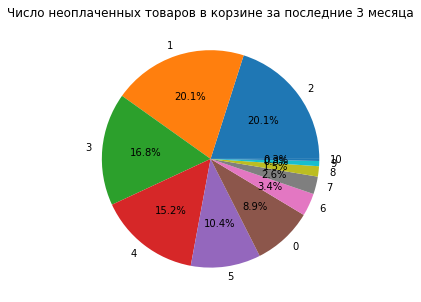

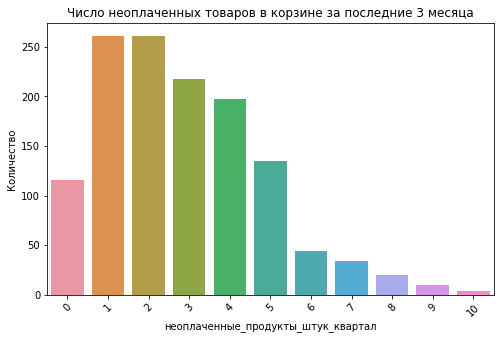

In [69]:
gistakat(
    data = market_file,
    column = 'неоплаченные_продукты_штук_квартал',
    title = 'Число неоплаченных товаров в корзине за последние 3 месяца'
)

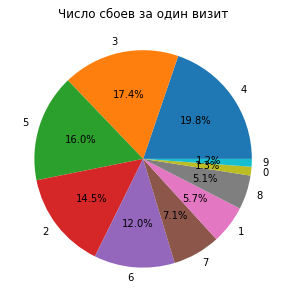

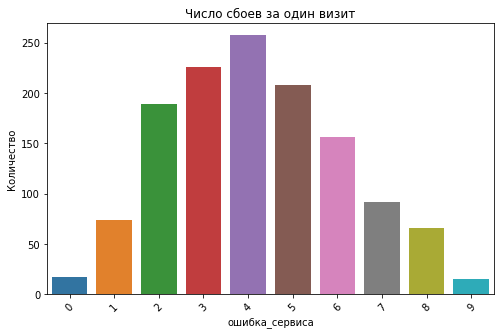

In [70]:
gistakat(
    data = market_file,
    column = 'ошибка_сервиса',
    title = 'Число сбоев за один визит'
)

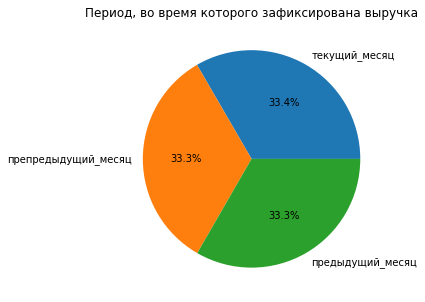

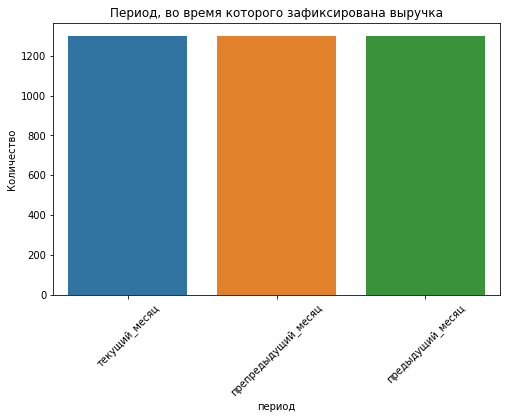

In [71]:
gistakat(
    data = market_money,
    column = 'период',
    title = 'Период, во время которого зафиксирована выручка'
)

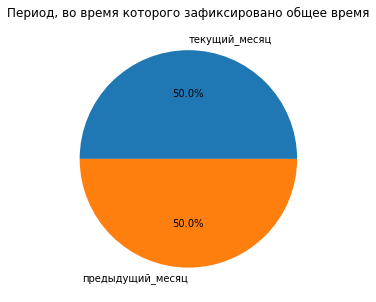

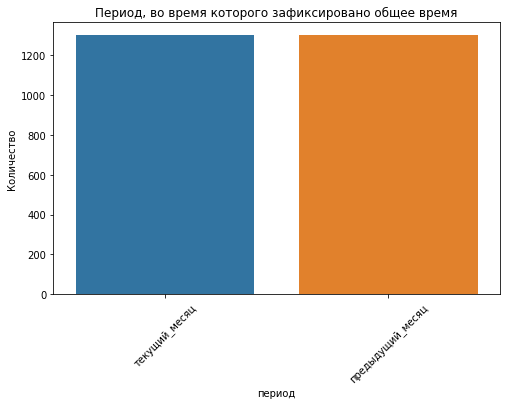

In [72]:
gistakat(
    data = market_time,
    column = 'период',
    title = 'Период, во время которого зафиксировано общее время'
)

 ## Отбор активных покупателей за последние 3 месяца

In [73]:
market_money_3m = market_file[market_file['id'].isin(money['id'])]
market_money_3m

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [74]:
unique_count = money['id'].nunique()
unique_count

1300

 ### Выводы
1. За последние 6 месяцев маркетинговая коммуникация с каждыми покупателем в среднем была 4-5 раз.
2. Большинство пользователей зарегистрированы на сайте от 400 до 800 дней.
3. Акционные товары покупают 17-30%, при этом есть отдельные редкие покупатели заинтересованные в этих товарах (90-100%).
4. В среднем посетитель просматривает от 5 до 11 страниц.
5. Вручка возросла в сравнении с предыдущим месяцем. 
6. Среднее время нахождения на сайте 10-16 минут.
7. У 38,3% пользователе снизилась покупательская активность.
8. 28,9% имеют премиумные уровень сервиса.
9. Только четверть пользователей отказываются от уведомлений.
10. В текущем месяце у половины пользователей было 4 маркетинговых взаимодействия.
11. Наиболее популярна категория "Товары для детей" (25,4%). Далее идут категории "Домашний текстиль" (19,3%) и "Косметика и аксессуары" (17,2%).
12. За раз посетители просматривают от 2 до 4 категорий.
13. У 72% в корзине находится 1-4 неоплаченных товара.
14. Больше половины сталкиваются от 3 до 4 сбоев на сайте за один визит.
15. Создана новая таблица активных пользователей за последние 3 месяца (market_money_3m).

# Объединение таблиц

In [75]:
# переименовываем одинаковые столбцы
df_1 = market_time[market_time['период']=='предыдущий_месяц'].copy()
df_1.rename(columns={'минут':'минут_предыдущего_месяца'},inplace=True)
df_1.drop('период', axis= 1, inplace= True)

df_2 = market_time[market_time['период']=='текущий_месяц'].copy()
df_2.rename(columns={'минут':'минут_текущего_месяца'},inplace=True)
df_2.drop('период', axis= 1, inplace= True)

df_market_time = pd.merge(df_1, df_2, on='id', sort=True)

print(df_market_time.info())
df_market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   id                        1300 non-null   int64
 1   минут_предыдущего_месяца  1300 non-null   int64
 2   минут_текущего_месяца     1300 non-null   int64
dtypes: int64(3)
memory usage: 30.6 KB
None


,id,минут_предыдущего_месяца,минут_текущего_месяца
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [76]:
df_1 = market_money[market_money['период']=='текущий_месяц'].copy()
df_1.rename(columns={'выручка':'выручка_предыдущего_месяца'},inplace=True)
df_1.drop('период', axis= 1, inplace= True)

df_2 = market_money[market_money['период']=='предыдущий_месяц'].copy()
df_2.rename(columns={'выручка':'выручка_текущего_месяца'},inplace=True)
df_2.drop('период', axis= 1, inplace= True)

df_3 = market_money[market_money['период']=='препредыдущий_месяц'].copy()
df_3.rename(columns={'выручка':'выручка_препредыдущего_месяца'},inplace=True)
df_3.drop('период', axis= 1, inplace= True)

In [77]:
df_market_money = pd.merge(df_1, df_2, on='id', sort=True)
df_market_money = pd.merge(df_3, df_market_money, on='id', sort=True)
print(df_market_money.info())
df_market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             1296 non-null   int64  
 1   выручка_препредыдущего_месяца  1296 non-null   float64
 2   выручка_предыдущего_месяца     1296 non-null   float64
 3   выручка_текущего_месяца        1296 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 40.6 KB
None


,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца
0,215349,4472.0,4971.6,5216.0
1,215350,4826.0,5058.4,5457.5
2,215351,4793.0,6610.4,6158.0
3,215352,4594.0,5872.5,5807.5
4,215353,5124.0,5388.5,4738.5


In [78]:
df = pd.merge(df_market_money, pd.merge(df_market_time, market_file, on='id', sort=True), on='id', sort=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   выручка_препредыдущего_месяца        1296 non-null   float64
 2   выручка_предыдущего_месяца           1296 non-null   float64
 3   выручка_текущего_месяца              1296 non-null   float64
 4   минут_предыдущего_месяца             1296 non-null   int64  
 5   минут_текущего_месяца                1296 non-null   int64  
 6   покупательская_активность            1296 non-null   object 
 7   тип_сервиса                          1296 non-null   object 
 8   разрешить_сообщать                   1296 non-null   object 
 9   маркет_актив_6_мес                   1296 non-null   float64
 10  маркет_актив_тек_мес                 1296 non-null   int64  
 11  длительность                  

,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,минут_предыдущего_месяца,минут_текущего_месяца,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215349,4472.0,4971.6,5216.0,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
1,215350,4826.0,5058.4,5457.5,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,4793.0,6610.4,6158.0,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
3,215352,4594.0,5872.5,5807.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,5124.0,5388.5,4738.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


In [79]:
print(df.sample(5))

          id  выручка_препредыдущего_месяца  выручка_предыдущего_месяца  \
1206  216558                         4457.0                      5147.0   
797   216149                         4820.0                      5946.8   
369   215721                         4513.0                      4447.5   
1073  216425                         4835.0                      4863.7   
118   215470                         4764.0                      5623.7   

      выручка_текущего_месяца  минут_предыдущего_месяца  \
1206                   4757.0                        15   
797                    5354.0                        19   
369                    4636.0                         6   
1073                   4072.0                        16   
118                    5157.0                        13   

      минут_текущего_месяца покупательская_активность тип_сервиса  \
1206                     16           Прежний уровень     премиум   
797                      17           Прежний уровень   

 ### Вывод:
Данные объединены по столбцу 'id'. Объединение прошло успешно. Переименованы столбцы.

# Корреляционный анализ

In [80]:
df = df.sort_values(by=['id']).set_index('id')

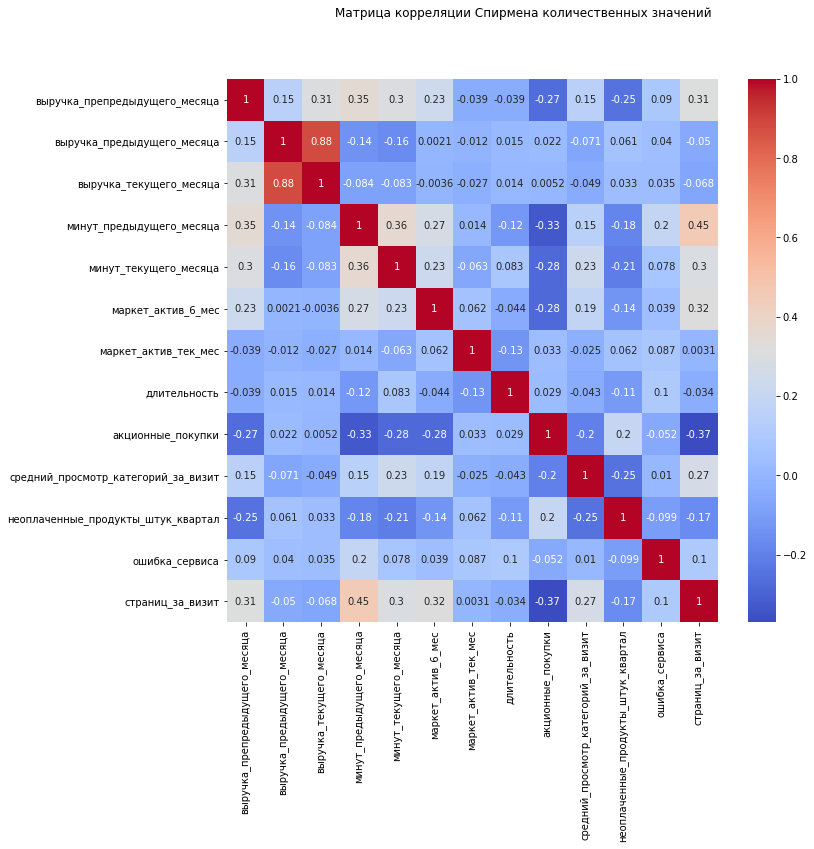

In [81]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции Спирмена количественных значений')
sns.heatmap(df.corr(method="spearman", numeric_only=True), annot=True, cmap='coolwarm');

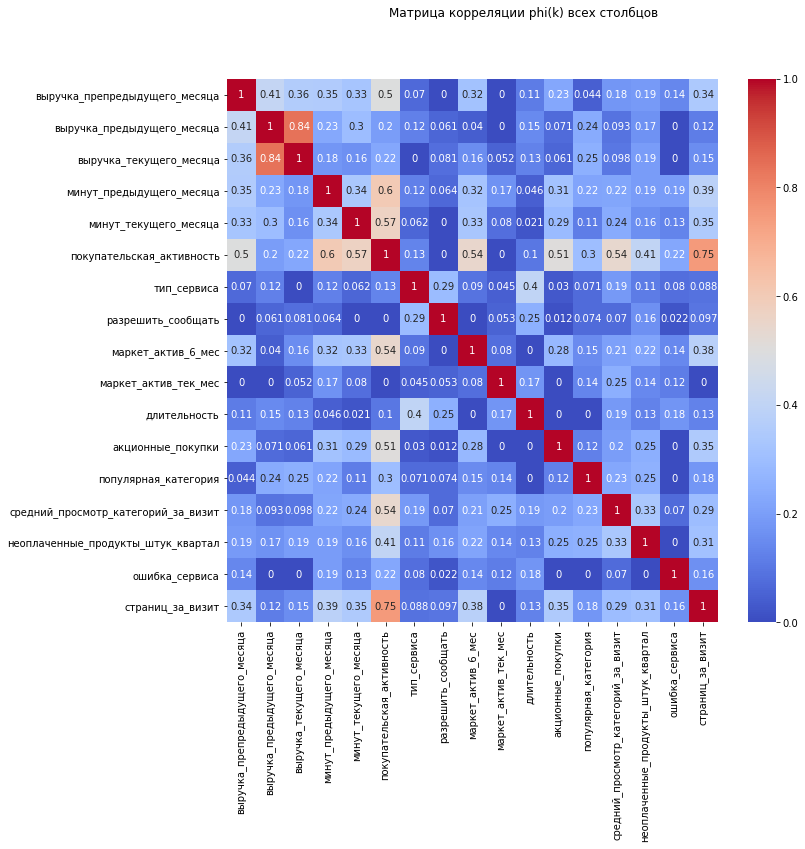

In [82]:
interval_cols = ['выручка_препредыдущего_месяца',
                 'выручка_предыдущего_месяца', 
                 'выручка_текущего_месяца',
                 'маркет_актив_6_мес',
                 'длительность',
                 'акционные_покупки'
                ]
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

 ### Выводы:
1. Максимальное значение корреляции Спирмена = 0,88 (выручка_текущего_месяца и выручка_предыдущего_месяца)
2. Максимальное знаяение корреляции phi(k) = 0,84 (выручка_текущего_месяца и выручка_предыдущего_месяца) и 0,75 (страниц_за_визит и покупательская_активность).
3. Нет корреляции выше 0.9, значит мультиколлинеарности нет
4. Покупатьльская_активность имеет среднюю корреляцию со многими признакам: выручка_препредыдущего_месяца (0,5); минут_предыдущего_месяца (0,6), минут_текущего_месяца (0,57), маркет_актив_6_мес (0,54), акционные_покупки (0,51), средний_просмотр_категорий_за_визит (0,54), популярная_категория (0,3), неоплаченные_продукты_штук_квартал (0,41).
5. Ошибка_сервиса практически не имеет корреляцию ни с одним из признаков, что может говорить о случайном характере ошибок.
6. Большинство показателей имеют низкую зависимость (близкую к 0).

# Использование пайплайнов

In [85]:
RANDOM_STATE = 42
X = df.drop(['покупательская_активность'], axis=1)
y = df['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify = y)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

le = LabelEncoder()
le.fit_transform(y_train.unique())
print ('Значениям', le.classes_, 'назначено соответственно', le.transform(le.classes_))
y_train = le.transform(y_train)
y_test = le.transform(y_test)

(972, 16)

(324, 16)

(972,)

(324,)

Значениям ['Прежний уровень' 'Снизилась'] назначено соответственно [0 1]


In [86]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']

In [87]:
num_columns = ['выручка_препредыдущего_месяца', 
               'выручка_предыдущего_месяца',
               'выручка_текущего_месяца',             
               'минут_предыдущего_месяца',            
               'минут_текущего_месяца',               
               'маркет_актив_тек_мес',                
               'длительность',                        
               'акционные_покупки',                   
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',  
               'ошибка_сервиса',
               'страниц_за_визит']

In [88]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [89]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['да', 'нет'],
                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [90]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

param_grid = [
    # словарь для модели SVC()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
#       'models__max_depth': range(1, 500),
        'models__max_depth': range(1, 450),
        'models__max_features': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
#   {
#       'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',penalty='l1')],
#       'models__C': range(1, 15),
#       'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
#   },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    }
]

model = RandomizedSearchCV(
                                pipe_final,
                                param_grid, 
                                cv=5,
                                scoring='roc_auc',
                                random_state=RANDOM_STATE,
                                n_jobs=-1
).fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', model.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', model.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [91]:
print('Площадь ROC-кривой на кросс-валидации:', model.best_score_)
roc_auc_model_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print('Площадь ROC-кривой на тестовой выборке:', roc_auc_model_test)
roc_auc_model_km = (roc_auc_model_test - model.best_score_) / model.best_score_*100
print(f'Потеря качества на тестовой выборке  = {-roc_auc_model_km:.2f} %')

Площадь ROC-кривой на кросс-валидации: 0.8664756334847243
Площадь ROC-кривой на тестовой выборке: 0.8976661408405129
Потеря качества на тестовой выборке  = -3.60 %


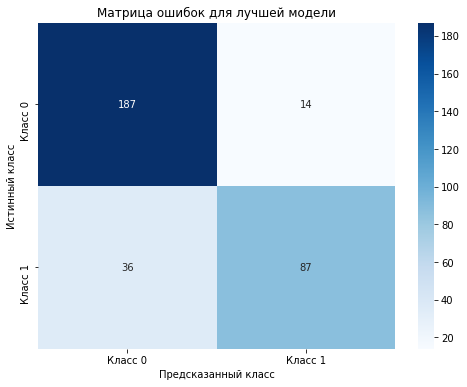

Истинно положительные (True Positive, TP): 187
Истинно отрицательные (True Negative, TN): 14
Ложноположительные (False Positive, FP): 36
Ложноотрицательные (False Negative, FN): 87
Accuracy (Точность): 0.85
Точность (Precision): 0.86
Полнота (Recall): 0.71
F1-мера: 0.78


In [92]:
# svc_best = svc.best_estimator_
svc_best = model.best_estimator_
y_pred_test = svc_best.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Класс 0', 'Класс 1'], yticklabels=['Класс 0', 'Класс 1'])
plt.title('Матрица ошибок для лучшей модели')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

TP, TN, FP, FN = conf_matrix.ravel()
print(f'Истинно положительные (True Positive, TP): {TP}')
print(f'Истинно отрицательные (True Negative, TN): {TN}')
print(f'Ложноположительные (False Positive, FP): {FP}')
print(f'Ложноотрицательные (False Negative, FN): {FN}')

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f'Accuracy (Точность): {accuracy:.2f}')
print(f'Точность (Precision): {precision:.2f}')
print(f'Полнота (Recall): {recall:.2f}')
print(f'F1-мера: {f1:.2f}')

 ### Выводы: 
1. Использовали пайплайн.
2. Подобрали лучшую модель и её гиперпараметры (SVC). 
3. Расчитали метрику лучшей модели (0,915).
4. Вывели матрицу ошибок модели. Точность 89%.

# Анализ важности признаков

In [93]:
#pipe_final = Pipeline([
#    ('preprocessor', data_preprocessor),
    #('models', KNeighborsClassifier(n_neighbors=10))
#    ('models', SVC(degree=3, probability=True, random_state=RANDOM_STATE))
#]).fit(X_train, y_train)


#best_model = knc.best_estimator_
best_model = model.best_estimator_
best_preprocessor = model.best_estimator_.named_steps['preprocessor']

# X_train_trans = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=data_preprocessor.get_feature_names_out())
# X_train_trans = X_train_trans.sample(frac=0.1, replace=True, random_state=42)
# X_test_trans = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())
# X_test_trans = X_test_trans.sample(frac=0.1, replace=True, random_state=42)

X_train_trans = pd.DataFrame(best_preprocessor.transform(X_train), columns=best_preprocessor.get_feature_names_out())
X_train_trans = X_train_trans.sample(frac=0.1, replace=True, random_state=42)
X_test_trans = pd.DataFrame(best_preprocessor.transform(X_test), columns=best_preprocessor.get_feature_names_out())
X_test_trans = X_test_trans.sample(frac=0.1, replace=True, random_state=42)

explainer = shap.KernelExplainer(best_model.named_steps['models'].predict, X_train_trans)
shap_values = explainer.shap_values(X_test_trans, nsamples=100)

  0%|          | 0/32 [00:00<?, ?it/s]

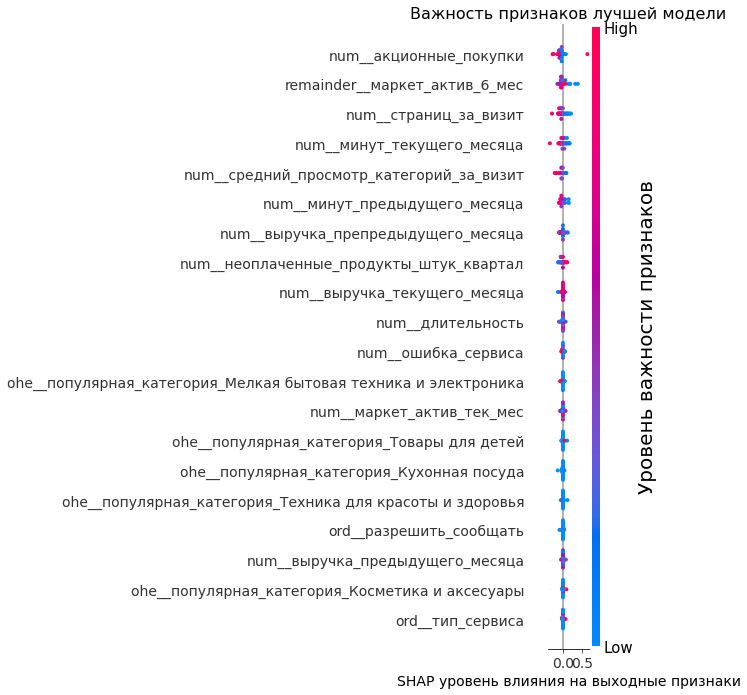

In [94]:
shap.initjs()
shap.summary_plot(shap_values, X_test_trans, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP уровень влияния на выходные признаки", fontsize=14)
ax.set_title('Важность признаков лучшей модели', fontsize=16)

cb_ax = fig.axes[1] 

cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Уровень важности признаков", fontsize=20)

plt.show()

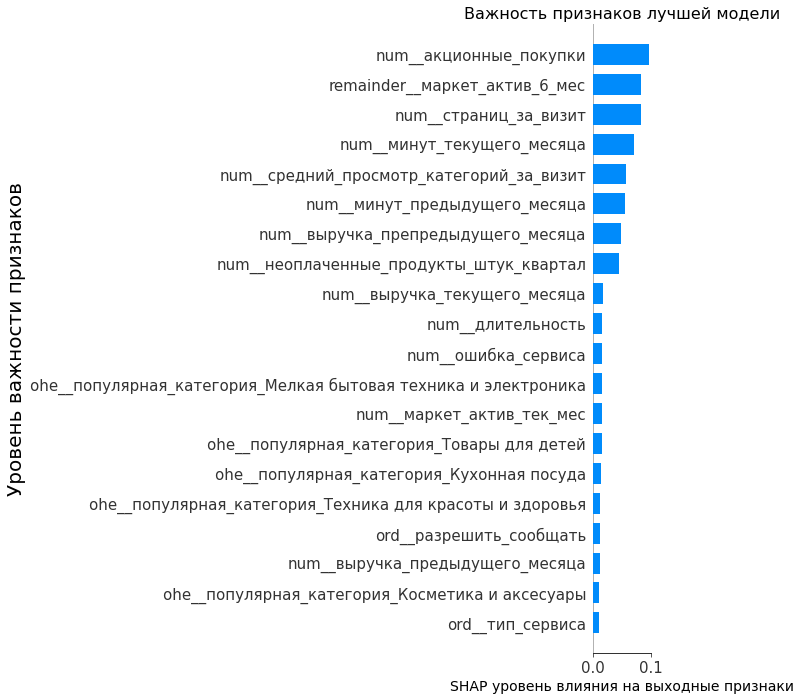

In [95]:
shap.initjs()
shap.summary_plot(shap_values, X_test_trans, plot_type='bar', show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP уровень влияния на выходные признаки", fontsize=14)
ax.set_title('Важность признаков лучшей модели', fontsize=16)
cb_ax = fig.axes[0] 
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Уровень важности признаков", fontsize=20)
plt.show();

 ### Вывод:
1. Лучшая модель SVC.
2. Наиболее важные признаки по убыванию: минут_предыдущего месяца, минут_текущего_месяца, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, акционные_покупки.
3. Наименее важные признаки: разрешить_сообщать, популярная_категория_Кухонная посуда, тип_сервиса.

# Сегментация покупателей

Сделаем прогноз модели с выбранным порогом и вероятностями.
Устанавливаем порог в +/- стандартное отклонение.

In [96]:
med = money['прибыль'].median()
sko = np.std(money['прибыль'])
print("Медианное значение : ", med)
print("Стандартное отклонение : ", sko)
money['прибыль'].describe()

Медианное значение :  4.045
Стандартное отклонение :  1.0133321434255445


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

In [97]:
def custom_predict(X, threshold):
    probs = best_model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

In [98]:
predictions_precision = custom_predict(X, threshold=0.5)
X['predictions'] = predictions_precision
X['probs'] = best_model.predict_proba(X)[:,1]

In [99]:
money['категории_прибыли'] = money['прибыль'].apply(lambda x: 'низко' if x < (med - sko) 
                                                       else ('высоко' if x > (med + sko) 
                                                       else 'средний'))

In [100]:
X = X.reset_index()
X = pd.merge(X, money, on='id', sort=True)
X.head()

,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,минут_предыдущего_месяца,минут_текущего_месяца,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,predictions,probs,прибыль,категории_прибыли
0,215349,4472.0,4971.6,5216.0,12,10,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,1,0.806416,4.16,средний
1,215350,4826.0,5058.4,5457.5,8,13,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,0,0.462726,3.13,средний
2,215351,4793.0,6610.4,6158.0,11,13,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,1,0.944244,4.87,средний
3,215352,4594.0,5872.5,5807.5,8,11,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,1,0.936918,4.21,средний
4,215353,5124.0,5388.5,4738.5,10,10,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,0,0.352545,3.95,средний


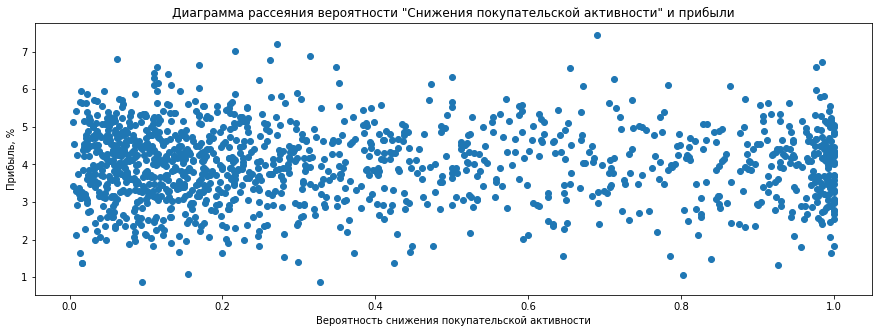

In [101]:
plt.figure(figsize=[15, 5])
plt.scatter(X.probs, X.прибыль);
plt.title('Диаграмма рассеяния вероятности "Снижения покупательской активности" и прибыли')
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль, %')
plt.show()

In [102]:
X['категория_снижения'] = X['probs'].apply(lambda x: 'Снизилась' if x > 0.7 else 'Прежний уровень')     

Клиентам, у которых снизилась покупательская активность, сделать персональное предложение и вернуть их за покупками. Введем котегориальный столбец в данные, для сравнения данных. Определим границу разделения 0.7 так как количество значений возрастает от этого порога.

Для работы выделим группу с малым доходом и высокой вероятностью снижения покупательской способности, для сравнения оставим группу с прежним уровнем активности.

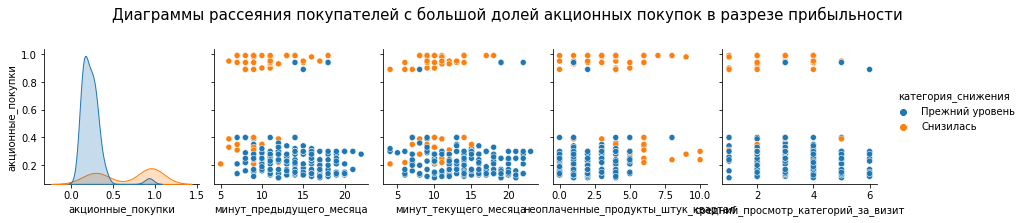

In [103]:
x=['акционные_покупки',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит']
y=['акционные_покупки']

g = sns.pairplot(X.query('категории_прибыли == "низко"'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=15)
plt.show()

Выделим группу клиентов, количество покупок акционных товаров не превышают 3 штук.

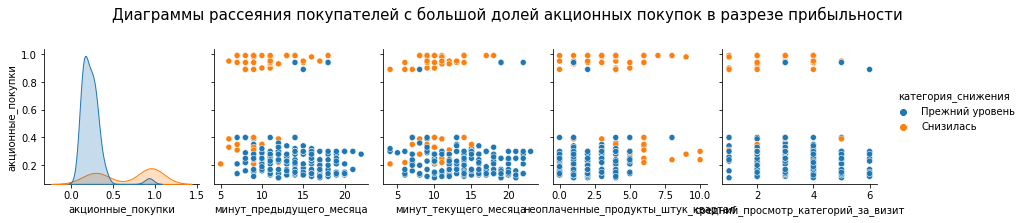

In [104]:
x=['акционные_покупки',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит']
y=['акционные_покупки']

g = sns.pairplot(X.query('категории_прибыли == "низко" & акционные_покупки < 3'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=15)
plt.show()

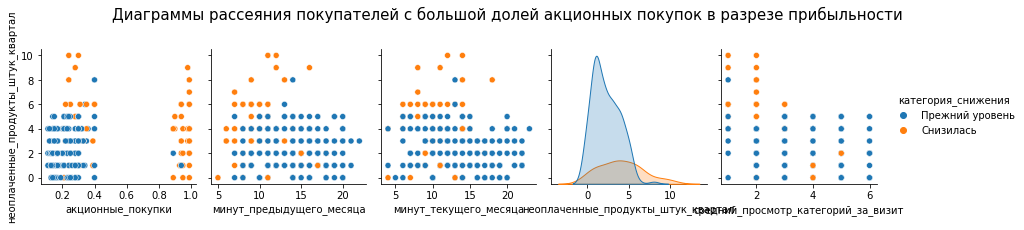

In [105]:
x=['акционные_покупки',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит']
y=['неоплаченные_продукты_штук_квартал']

g = sns.pairplot(X.query('категории_прибыли == "низко"'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=15)
plt.show()

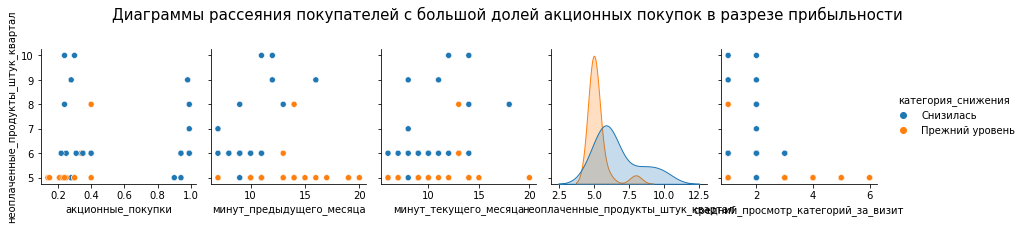

In [106]:
x=['акционные_покупки',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит']
y=['неоплаченные_продукты_штук_квартал']

g = sns.pairplot(X.query('категории_прибыли == "низко" & неоплаченные_продукты_штук_квартал > 4'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=15)
plt.show()

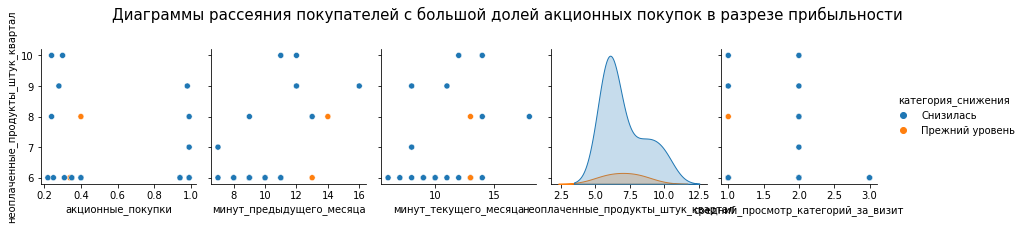

In [107]:
x=['акционные_покупки',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит']
y=['неоплаченные_продукты_штук_квартал']

g = sns.pairplot(X.query('категории_прибыли == "низко" & неоплаченные_продукты_штук_квартал > 5'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=15)
plt.show()

 ### Выводы:
 1. Наиболее показательными диаграммы являются для клиентов с неоплаченные_продукты_штук_квартал. Практически у всех клиентов от 4 неоплаченых товаров в корзине наблюдается снижение потребительской активности.
 2. Для повторного привлечения клиентов можно отправлять напоминания при нахождении в корзине более 3х товаров с некоторой периодичностью.
 3. Удержание внимания на страницах сайта. При просмотре более 6 страниц покупательская активность сохраняется. Увеличение числа просмотренных страниц приведет к увеличению времени, проведенного на сайте.
 4. Акционные товары также благотворно влияют на активность.

# Общий вывод

**Задача исследования**

Целью исследования было разработать решение для персонализации предложений постоянным клиентам, чтобы увеличить их покупательскую активность. Для анализа были предоставлены следующие данные:

- **market_file.csv** — данные о поведении покупателя на сайте, коммуникациях с ним и его продуктовом поведении.
- **market_money.csv** — данные о выручке, получаемой магазином от покупателя за период взаимодействия.
- **market_time.csv** — данные о времени, проведенном покупателем на сайте в течение периода.
- **money.csv** — данные о среднемесячной прибыли покупателя за последние три месяца.

В ходе **предобработки данных** были переименованы столбцы, обработаны дубликаты, проверены пропуски и соответствия типа данных.

Для **поиска лучшей модели** были проведены:
 - изучены и предобработанны данные
 - исследованы взаимосвязи количественных признаков с помощью корреляционного анализа
 - объединены данные чтобы у модели были больше признаков для обучения
 - настроенна автоматизация обучения с помощью пайплайнов
 - проведён расчёт метрик
 - на основе выбранной модели был построен график с параметрами, которые сильнее всего влияют предсказание. 

**Лучшая модель**

Наилучшей моделью была определена **SVC (degree=5, probability=True, random_state=42)**

- Accuracy (Точность): 0.89
- Точность (Precision): 0.89
- Полнота (Recall): 0.80
- F1-мера: 0.84

**Выводы и дополнительные предложения**

  Наиболее показательными диаграммы являются для клиентов с неоплаченные_продукты_штук_квартал. Практически у всех клиентов от 4 неоплаченых товаров в корзине наблюдается снижение потребительской активности. Для повторного привлечения клиентов можно отправлять напоминания при нахождении в корзине более 3х товаров с некоторой периодичностью.
 
 Удержание внимания на страницах сайта. При просмотре более 6 страниц покупательская активность сохраняется. Увеличение числа просмотренных страниц приведет к увеличению времени, проведенного на сайте. Акционные товары также благотворно влияют на активность.